In [1468]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve, roc_curve, auc, log_loss, roc_auc_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, StratifiedShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, VotingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder

from lightgbm import LGBMClassifier, LGBMRegressor, early_stopping 
import lightgbm as lgbm
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor
import catboost as cat
from sklearn.multioutput import MultiOutputRegressor
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings("ignore")

In [1469]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [1470]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(909) # Seed 고정

In [1471]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

train.shape, test.shape

((14095, 54), (6041, 19))

In [1472]:
percent20UP = ['FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4', 'FTBN', 'FUEL', 'SOOTPERCENTAGE', 'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V100']
train = train.drop(percent20UP, axis=1)

In [1473]:
train = train.fillna(0)
test = test.fillna(0)

In [1474]:
train_X = train.drop(['ID', 'Y_LABEL'], axis = 1)
train_y = train['Y_LABEL']

test = test.drop(['ID'], axis = 1)

In [1475]:
categorical_features = ['COMPONENT_ARBITRARY', 'YEAR']
test_stage_features = ['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR' , 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']

def get_values(value):
    return value.values.reshape(-1, 1)

for col in train_X.columns:
    if col not in categorical_features:
        scaler = StandardScaler()
        train_X[col] = scaler.fit_transform(get_values(train_X[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))
            
le = LabelEncoder()
for col in categorical_features:    
    train_X[col] = le.fit_transform(train_X[col])
    if col in test.columns:
        test[col] = le.transform(test[col])
        
train_X.shape, train_y.shape, test.shape

((14095, 35), (14095,), (6041, 18))

In [1476]:
train_sub = train_X[test_stage_features]

## Optuna - Best Parameters 찾기

### Optuna - Teacher Model

In [1478]:
def objectiveXGB(trial: Trial) -> float:
    param = {'verbosity':1,
             'eval_metric': 'logloss',
             'objective':'binary:logistic',
             'max_depth':trial.suggest_int('max_depth',2,10),
             'subsample':trial.suggest_uniform('subsample',0.7,1),
             'n_estimators':trial.suggest_int('n_estimators',100,1000),
             'learning_rate':trial.suggest_loguniform('learning_rate',0.1,0.2),
             'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
             'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
             'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),             
             'min_child_weight': trial.suggest_loguniform('min_child_weight', 1, 5),
             'min_split_loss': trial.suggest_float('gamma', 0.1, 1, log=True), # gamma
             'lambda': trial.suggest_float('lambda', 1e-3, 1, log=True), # lambda
             'alpha': trial.suggest_float('alpha', 1e-3, 1, log=True), # alpha
             'random_state': 909}
    
    fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=909)
    
    cv_scores = []
    for train_idx, val_idx in fold.split(train_X, train_y):
        tri_X, val_X = train_X.iloc[train_idx], train_X.iloc[val_idx]
        tri_y, val_y = train_y.iloc[train_idx], train_y.iloc[val_idx]

        XGBmodel = XGBClassifier(**param, n_jobs=-1, tree_method='gpu_hist', predictor='gpu_predictor')
        XGBmodel.fit(tri_X, tri_y, eval_set=[(val_X, val_y)],
                     early_stopping_rounds=50, verbose=False)
        
        y_pred = XGBmodel.predict(val_X)
        score = f1_score(val_y, y_pred)

        cv_scores.append(score)
        
    return np.mean(cv_scores)

sampler = TPESampler(seed=909)
studyXGB = optuna.create_study(direction="maximize", sampler=sampler)

studyXGB.optimize(objectiveXGB, n_trials=1000)
print("Best Score:", studyXGB.best_value)
print("Best trial:", studyXGB.best_trial.params)

# F1 - 35 rows
# Best Score: 0.67719009128271
# Best trial: {'max_depth': 5, 'subsample': 0.8688969525162259, 'n_estimators': 352, 'learning_rate': 0.1343112950285281, 'colsample_bytree': 0.9343657430339303, 'colsample_bylevel': 0.896615518212377, 'colsample_bynode': 0.6938577760914412, 'min_child_weight': 1.0798588029167075, 'gamma': 0.4940116661541142, 'reg_lambda': 0.06180773813466094, 'reg_alpha': 0.017583371233474643}

[I 2022-12-13 01:33:46,780] A new study created in memory with name: no-name-83300bc6-6c8e-4c93-a1ed-f978bbc6c0e4
[I 2022-12-13 01:33:50,256] Trial 0 finished with value: 0.6664125832532555 and parameters: {'max_depth': 6, 'subsample': 0.7213230815622785, 'n_estimators': 308, 'learning_rate': 0.1279455584147545, 'colsample_bytree': 0.5932823420444893, 'colsample_bylevel': 0.7123785474123051, 'colsample_bynode': 0.8861639211216272, 'min_child_weight': 1.7034328304366713, 'gamma': 0.11835023025093547, 'lambda': 0.03768530651187684, 'alpha': 0.003926316383947766}. Best is trial 0 with value: 0.6664125832532555.
[I 2022-12-13 01:33:54,861] Trial 1 finished with value: 0.6643719352840668 and parameters: {'max_depth': 9, 'subsample': 0.7057075638520239, 'n_estimators': 298, 'learning_rate': 0.11163109109313471, 'colsample_bytree': 0.9006735507672843, 'colsample_bylevel': 0.8079333427519012, 'colsample_bynode': 0.8058195161025692, 'min_child_weight': 3.7733489697799927, 'gamma': 0.14505683011

Best Score: 0.6757622568154019
Best trial: {'max_depth': 6, 'subsample': 0.7434404184911538, 'n_estimators': 337, 'learning_rate': 0.18439463183043792, 'colsample_bytree': 0.9635175019204961, 'colsample_bylevel': 0.9998449129032241, 'colsample_bynode': 0.5965596225712301, 'min_child_weight': 3.369253166637767, 'gamma': 0.7216326368600137, 'lambda': 0.019576232608724348, 'alpha': 0.4937120134784053}


In [1479]:
def objectiveCAT(trial: Trial) -> float:
    param = {
        'max_depth' : trial.suggest_int('depth', 10, 16),
        'n_estimators' : trial.suggest_int('n_estimators', 4000, 8000),         
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.03),
        'random_strength' :trial.suggest_int('random_strength', 50, 100),
        'fold_permutation_block' : trial.suggest_int('fold_permutation_block', 100, 180),   
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 1, 5),
        'od_pval' : trial.suggest_float('od_pval', 0, 1),
        'l2_leaf_reg' : trial.suggest_float('l2_leaf_reg', 1e-8, 3e-5),
        'random_state': 909}
        
    fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=909)
    
    cv_scores = []
    for train_idx, val_idx in fold.split(train_X, train_y):
        tri_X, val_X = train_X.iloc[train_idx], train_X.iloc[val_idx]
        tri_y, val_y = train_y.iloc[train_idx], train_y.iloc[val_idx]

        CATmodel = CatBoostClassifier(**param, grow_policy='Lossguide', task_type='GPU', silent=True)
        CATmodel.fit(tri_X, tri_y, eval_set=[(val_X, val_y)],
                     early_stopping_rounds=50, verbose=False)
        
        y_pred = CATmodel.predict(val_X)
        score = f1_score(val_y, y_pred)

        cv_scores.append(score)
        
    return np.mean(cv_scores)

sampler = TPESampler(seed=909)
studyCAT = optuna.create_study(
    study_name="CatBoost",
    direction="maximize",
    sampler=sampler,
)

studyCAT.optimize(objectiveCAT, n_trials=1000)
print("Best Score:", studyCAT.best_value)
print("Best trial:", studyCAT.best_trial.params)

# F1 - 35 rows
# Best Score: 0.6741889198980741
# Best trial: {'depth': 15, 'n_estimators': 5710, 'learning_rate': 0.027163694584269395, 'random_strength': 83, 'fold_permutation_block': 137, 'bagging_temperature': 2.6797821381025617, 'od_pval': 0.5862086802468089, 'l2_leaf_reg': 2.389512664227257e-05}

[I 2022-12-13 02:16:55,044] A new study created in memory with name: CatBoost
[I 2022-12-13 02:17:54,878] Trial 0 finished with value: 0.6679798950222607 and parameters: {'depth': 13, 'n_estimators': 4284, 'learning_rate': 0.01289291987199198, 'random_strength': 68, 'fold_permutation_block': 115, 'bagging_temperature': 1.9810364591937373, 'od_pval': 0.7723278422432546, 'l2_leaf_reg': 9.935228697379753e-06}. Best is trial 0 with value: 0.6679798950222607.
[I 2022-12-13 02:18:56,528] Trial 1 finished with value: 0.6683904257371427 and parameters: {'depth': 10, 'n_estimators': 6102, 'learning_rate': 0.012429900990456032, 'random_strength': 92, 'fold_permutation_block': 101, 'bagging_temperature': 1.4248340170850848, 'od_pval': 0.15873889740794955, 'l2_leaf_reg': 2.404239957502171e-05}. Best is trial 1 with value: 0.6683904257371427.
[I 2022-12-13 02:19:30,658] Trial 2 finished with value: 0.6641877968268005 and parameters: {'depth': 14, 'n_estimators': 6447, 'learning_rate': 0.02475582497

Best Score: 0.673275307395118
Best trial: {'depth': 16, 'n_estimators': 4278, 'learning_rate': 0.027693985644803847, 'random_strength': 74, 'fold_permutation_block': 109, 'bagging_temperature': 2.126937139196386, 'od_pval': 0.8656802411408805, 'l2_leaf_reg': 6.7373128182810205e-06}


In [1480]:
def objectiveLGBM(trial: Trial) -> float:
    param = {        
        'num_leaves': trial.suggest_int('num_leaves', 100, 200, step=1, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 0.1, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 20),
        'min_child_weight': trial.suggest_uniform('min_child_weight', 0, 1),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }
    
    fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=909)
    
    cv_scores = []
    for train_idx, val_idx in fold.split(train_X, train_y):
        tri_X, val_X = train_X.iloc[train_idx], train_X.iloc[val_idx]
        tri_y, val_y = train_y.iloc[train_idx], train_y.iloc[val_idx]

        LGBMmodel = LGBMClassifier(**param, n_jobs=-1, random_state=909)
        LGBMmodel.fit(tri_X, tri_y, eval_set=[(val_X, val_y)],
                     callbacks=[early_stopping(stopping_rounds=50, verbose=False)])
        
        y_pred = LGBMmodel.predict(val_X)
        score = f1_score(val_y, y_pred)

        cv_scores.append(score)
        
    return np.mean(cv_scores)
    
sampler = TPESampler(seed=909)
studyLGBM = optuna.create_study(
    study_name="LGBMBoost",
    direction="maximize",
    sampler=sampler,
)

studyLGBM.optimize(objectiveLGBM, n_trials=1000)
print("Best Score:", studyLGBM.best_value)
print("Best trial:", studyLGBM.best_trial.params)

# F1 - 35 rows
# Best Score: 0.6781686601732926
# Best trial: {'num_leaves': 114, 'max_depth': 10, 'learning_rate': 0.29396016109519013, 'n_estimators': 738, 'min_child_samples': 15, 'min_child_weight': 0.4423169569421409, 'reg_alpha': 0.26418900951233526, 'reg_lambda': 0.8636399992806805, 'subsample': 0.917252305601001}

[I 2022-12-13 16:09:55,350] A new study created in memory with name: LGBMBoost
[I 2022-12-13 16:09:55,997] Trial 0 finished with value: 0.6667398579486846 and parameters: {'num_leaves': 137, 'max_depth': 5, 'learning_rate': 0.12892919871991979, 'n_estimators': 678, 'min_child_samples': 12, 'min_child_weight': 0.4247570948246102, 'reg_alpha': 0.7723278422432546, 'reg_lambda': 0.33095127367054866, 'subsample': 0.42773708604237015}. Best is trial 0 with value: 0.6667398579486846.
[I 2022-12-13 16:09:56,662] Trial 1 finished with value: 0.6677720700327472 and parameters: {'num_leaves': 144, 'max_depth': 7, 'learning_rate': 0.251749758198068, 'n_estimators': 509, 'min_child_samples': 12, 'min_child_weight': 0.15873889740794955, 'reg_alpha': 0.8013471015345685, 'reg_lambda': 0.6158666855038024, 'subsample': 0.70057660932281}. Best is trial 1 with value: 0.6677720700327472.
[I 2022-12-13 16:09:57,166] Trial 2 finished with value: 0.664153943120079 and parameters: {'num_leaves': 177, 'max_dept

Best Score: 0.6781686601732926
Best trial: {'num_leaves': 114, 'max_depth': 10, 'learning_rate': 0.29396016109519013, 'n_estimators': 738, 'min_child_samples': 15, 'min_child_weight': 0.4423169569421409, 'reg_alpha': 0.26418900951233526, 'reg_lambda': 0.8636399992806805, 'subsample': 0.917252305601001}


## Teacher Modeling

In [1462]:
# studyXGB.best_trial.params
# 52 - XGB_params = {'max_depth': 9, 'subsample': 0.6284819175591568, 'n_estimators': 2329, 'learning_rate': 0.03041135518918272, 'colsample_bytree': 0.9236317966396387, 'colsample_bylevel': 0.7855842277237282, 'colsample_bynode': 0.9662446264653861, 'min_child_weight': 2.402673539399719, 'gamma': 0.4885835354198732, 'reg_lambda': 0.015137844275921969, 'reg_alpha': 0.419131762058263}
# 35 - 
XGB_params = {'max_depth': 5, 'subsample': 0.8688969525162259, 'n_estimators': 352, 'learning_rate': 0.1343112950285281, 'colsample_bytree': 0.9343657430339303, 'colsample_bylevel': 0.896615518212377, 'colsample_bynode': 0.6938577760914412, 'min_child_weight': 1.0798588029167075, 'gamma': 0.4940116661541142, 'reg_lambda': 0.06180773813466094, 'reg_alpha': 0.017583371233474643}
XGB_model = XGBClassifier(**XGB_params, n_jobs=-1, tree_method='gpu_hist', predictor='gpu_predictor', eval_metric='logloss', random_state=909, use_label_encoder=False)

# studyCAT.best_trial.params
# 52 - CAT_params = {'depth': 16, 'n_estimators': 1046, 'learning_rate': 0.013874892667957453, 'random_strength': 95, 'fold_permutation_block': 197, 'bagging_temperature': 2.149457859920411, 'od_pval': 0.8436032986114058, 'l2_leaf_reg': 5.594175984672342e-06}
# 35 -
CAT_params = {'depth': 15, 'n_estimators': 5710, 'learning_rate': 0.027163694584269395, 'random_strength': 83, 'fold_permutation_block': 137, 'bagging_temperature': 2.6797821381025617, 'od_pval': 0.5862086802468089, 'l2_leaf_reg': 2.389512664227257e-05}
CAT_model = CatBoostClassifier(**CAT_params, grow_policy='Lossguide', task_type='GPU', random_state=909, silent=True)

# studyLGBM.best_trial.params
# 52 - LGBM_params = {'num_leaves': 75, 'max_depth': 28, 'learning_rate': 0.11617209687634066, 'n_estimators': 2277, 'min_child_samples': 30, 'min_child_weight': 0.3281130702276898}
# 35 -
LGBM_params = {'num_leaves': 152, 'max_depth': 10, 'learning_rate': 0.21670011792940466, 'n_estimators': 829, 'min_child_samples': 16, 'min_child_weight': 0.22388071602661894, 'reg_alpha': 0.21658597494115142, 'reg_lambda': 0.5701113568843794, 'subsample': 0.5293764776767426}
LGBM_model = LGBMClassifier(**LGBM_params, n_jobs=-1, random_state=909)

VOT_model = VotingClassifier(estimators = [('XGB', XGB_model), ('CAT', CAT_model), ('LGBM', LGBM_model),], voting = 'soft')

### Check f1-score, threshold

In [1463]:
def f1_manual(precision, recall):
  '''
  precision, recall: 1d array
  ----
  return: 1d array
  '''
  return (2 * precision * recall) / (precision + recall)

In [1464]:
X_tr_, X_val_, y_tr_, y_val_ = train_test_split(train_X, train_y, test_size=0.2, shuffle=True, random_state=909, stratify=train_y)

In [1465]:
XGB_model.fit(X_tr_, y_tr_)
XGB_pred = XGB_model.predict_proba(X_val_)[:, 1]

CAT_model.fit(X_tr_, y_tr_)
CAT_pred = CAT_model.predict_proba(X_val_)[:, 1]

LGBM_model.fit(X_tr_, y_tr_)
LGBM_pred = LGBM_model.predict_proba(X_val_)[:, 1]

VOT_model.fit(X_tr_, y_tr_)
VOT_pred = VOT_model.predict_proba(X_val_)[:, 1]

In [1466]:
VOT_model = VotingClassifier(estimators = [('XGB', XGB_model), ('CAT', CAT_model), ('LGBM', LGBM_model),], weights=[3, 3, 5], voting = 'soft')
VOT_model.fit(X_tr_, y_tr_)
VOT_pred = VOT_model.predict_proba(X_val_)[:, 1]

In [1467]:
XGB_roc = roc_auc_score(y_val_, XGB_pred)
XGB_prec, XGB_recall, XGB_th = precision_recall_curve(y_val_, XGB_pred)
XGB_f1 = np.nanmax(f1_manual(XGB_prec, XGB_recall))
print('XGB model - ROC AUC: %.4f, Maximum F1 score: %.4f' % (XGB_roc, XGB_f1))

CAT_roc = roc_auc_score(y_val_, CAT_pred)
CAT_prec, CAT_recall, CAT_th = precision_recall_curve(y_val_, CAT_pred)
CAT_f1 = np.nanmax(f1_manual(CAT_prec, CAT_recall))
print('CatBoost model - ROC AUC: %.4f, Maximum F1 score: %.4f' % (CAT_roc, CAT_f1))

LGBM_roc = roc_auc_score(y_val_, LGBM_pred)
LGBM_prec, LGBM_recall, LGBM_th = precision_recall_curve(y_val_, LGBM_pred)
LGBM_f1 = np.nanmax(f1_manual(LGBM_prec, LGBM_recall))
print('LGBM model - ROC AUC: %.4f, Maximum F1 score: %.4f' % (LGBM_roc, LGBM_f1))

VOT_roc = roc_auc_score(y_val_, VOT_pred)
VOT_prec, VOT_recall, VOT_th = precision_recall_curve(y_val_, VOT_pred)
VOT_f1 = np.nanmax(f1_manual(VOT_prec, VOT_recall))
print('VOT model - ROC AUC: %.4f, Maximum F1 score: %.4f' % (VOT_roc, VOT_f1))

# ROC curve를 그리기 위해 False Positive Rate과 True Positive Rate을 가져옵니다.
XGB_fpr, XGB_tpr, XGB_th2 = roc_curve(y_val_, XGB_pred)
CAT_fpr, CAT_tpr, CAT_th2 = roc_curve(y_val_, CAT_pred)
LGBM_fpr, LGBM_tpr, LGBM_th2 = roc_curve(y_val_, LGBM_pred)
VOT_fpr, VOT_tpr, VOT_th2 = roc_curve(y_val_, VOT_pred)

XGB model - ROC AUC: 0.8897, Maximum F1 score: 0.6833
CatBoost model - ROC AUC: 0.8830, Maximum F1 score: 0.6854
LGBM model - ROC AUC: 0.8846, Maximum F1 score: 0.6842
VOT model - ROC AUC: 0.8886, Maximum F1 score: 0.6880


### Find Threshold

In [1293]:
# F1 score를 가장 높여주는 threshold를 찾습니다.
XGB_f1 = f1_manual(XGB_prec, XGB_recall)
XGB_max = np.nanmax(XGB_f1)
XGB_argmax = np.argmax(np.where(XGB_f1 == XGB_max, 1, 0))
XGB_maxth = XGB_th[XGB_argmax]

CAT_f1 = f1_manual(CAT_prec, CAT_recall)
CAT_max = np.nanmax(CAT_f1)
CAT_argmax = np.argmax(np.where(CAT_f1 == CAT_max, 1, 0))
CAT_maxth = CAT_th[CAT_argmax]

LGBM_f1 = f1_manual(LGBM_prec, LGBM_recall)
LGBM_max = np.nanmax(LGBM_f1)
LGBM_argmax = np.argmax(np.where(LGBM_f1 == LGBM_max, 1, 0))
LGBM_maxth = LGBM_th[LGBM_argmax]

VOT_f1 = f1_manual(VOT_prec, VOT_recall)
VOT_max = np.nanmax(VOT_f1)
VOT_argmax = np.argmax(np.where(VOT_f1 == VOT_max, 1, 0))
VOT_maxth = VOT_th[VOT_argmax]

print('XGB - Maximum F1: %.4f, Threshold: %.4f' % (XGB_max, XGB_maxth))
print('CAT - Maximum F1: %.4f, Threshold: %.4f' % (CAT_max, CAT_maxth))
print('LGBM - Maximum F1: %.4f, Threshold: %.4f' % (LGBM_max, LGBM_maxth))
print('VOT - Maximum F1: %.4f, Threshold: %.4f' % (VOT_max, VOT_maxth))

XGB - Maximum F1: 0.6833, Threshold: 0.3310
CAT - Maximum F1: 0.6856, Threshold: 0.2185
LGBM - Maximum F1: 0.6842, Threshold: 0.4598
VOT - Maximum F1: 0.6844, Threshold: 0.4220


#### Precision, Recall 그래프

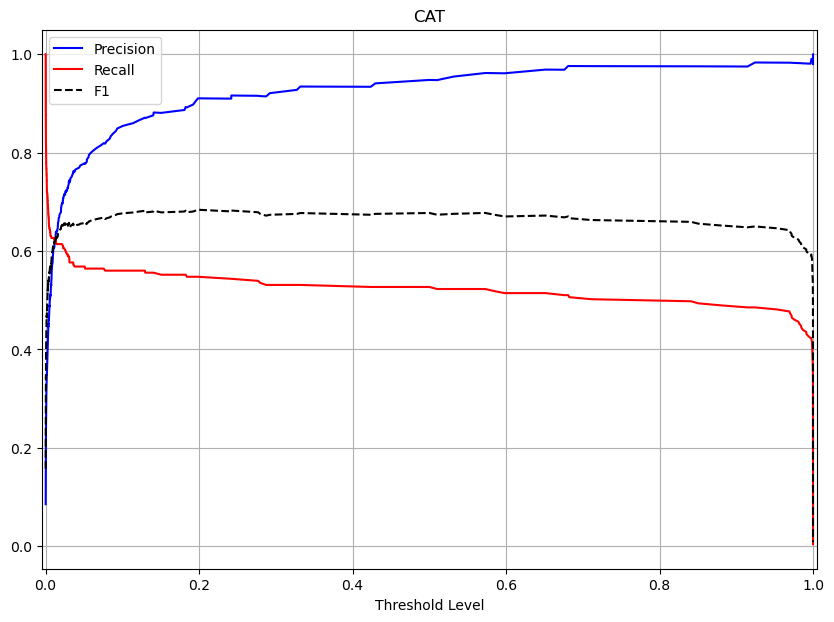

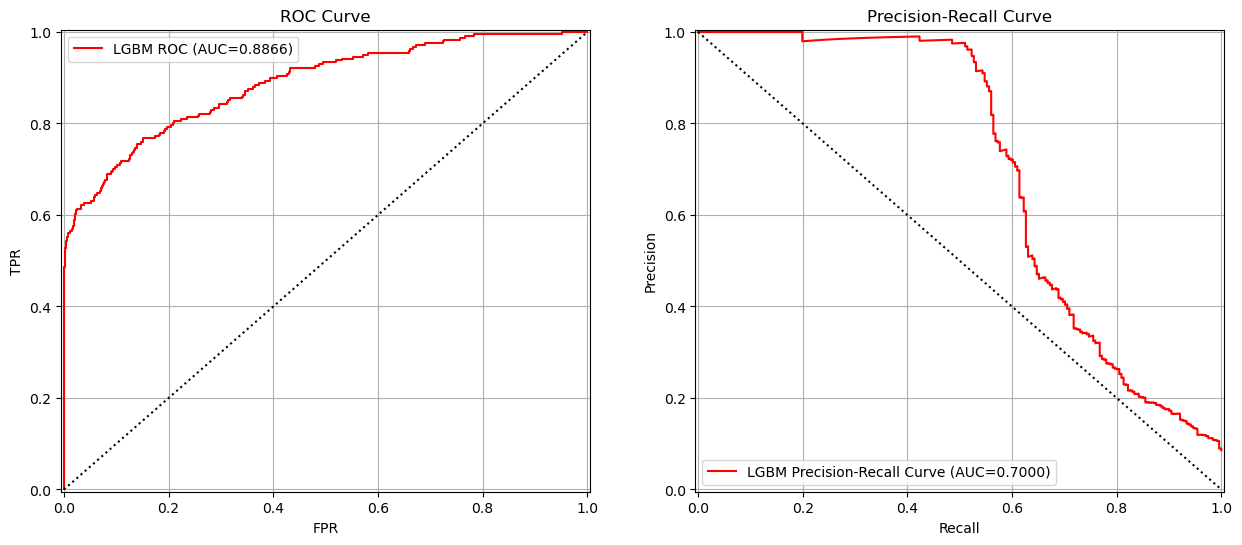

In [1164]:
# Precision, Recall 그리기

plt.figure(figsize=(10, 7))
plt.plot(CAT_th, CAT_prec[:-1], 'b-', label='Precision')
plt.plot(CAT_th, CAT_recall[:-1], 'r-', label='Recall')
plt.plot(CAT_th, f1_manual(CAT_prec, CAT_recall)[:-1], 'k--', label='F1')
plt.xlabel('Threshold Level')
plt.title('CAT')
plt.xlim([-0.005, 1.005])
plt.legend()
plt.grid(True)
plt.show()

# ROC와 Precision-Recall curve를 그려봅니다.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC curve
ax1.plot(CAT_fpr, CAT_tpr, 'r-', label='LGBM ROC (AUC=%.4f)' % auc(CAT_fpr, CAT_tpr))
ax1.plot([0, 1], [0, 1], 'k:')
ax1.set_xlabel('FPR')
ax1.set_ylabel('TPR')
ax1.set_title('ROC Curve')
ax1.set_xlim([-0.005, 1.005])
ax1.set_ylim([-0.005, 1.005])
ax1.legend()
ax1.grid(True)

# Precision-Recall curve
ax2.plot(CAT_recall, CAT_prec, 'r-', label='LGBM Precision-Recall Curve (AUC=%.4f)' % auc(CAT_recall, CAT_prec))
ax2.plot([0, 1], [1, 0], 'k:')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.set_xlim([-0.005, 1.005])
ax2.set_ylim([-0.005, 1.005])
ax2.legend()
ax2.grid(True)

## Student Modeling - NN

In [1022]:
class CustomDataset(Dataset):
    def __init__(self, data_X, data_y, distillation=False):
        super(CustomDataset, self).__init__()
        self.data_X = data_X
        self.data_y = data_y
        self.distillation = distillation
        
    def __len__(self):
        return len(self.data_X)
    
    def __getitem__(self, index):
        if self.distillation:
            # 지식 증류 학습 시
            teacher_X = torch.Tensor(self.data_X.iloc[index])
            student_X = torch.Tensor(self.data_X[test_stage_features].iloc[index])
            y = self.data_y.values[index]
            return teacher_X, student_X, y, index
        else:
            if self.data_y is None:
                test_X = torch.Tensor(self.data_X.iloc[index])
                return test_X
            else:
                teacher_X = torch.Tensor(self.data_X.iloc[index])
                y = self.data_y.values[index]
                return teacher_X, y

In [1023]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

In [1024]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=18, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [1025]:
def distillation(student_logits, labels, teacher_logits, alpha):
    distillation_loss = nn.BCELoss()(student_logits.squeeze(), teacher_logits)
    student_loss = nn.BCELoss()(student_logits, labels.reshape(-1, 1))
    return alpha * student_loss + (1-alpha) * distillation_loss

def distill_loss(output, target, teacher_output, loss_fn=distillation, opt=None):
    loss_b = loss_fn(output, target, teacher_output, alpha=0.1)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item()

In [1027]:
def student_train(s_model, t_model, optimizer, train_loader, val_loader, scheduler, device):
    s_model.to(device)
    # t_model.to(device)

    best_score = 0
    best_model = None

    for epoch in range(30):
        train_loss = []
        s_model.train()
        # t_model.eval()
        
        for X_t, X_s, y, idx in tqdm(train_loader):
            X_t_ = X_tr_.iloc[idx]            
            X_s = X_s.float().to(device)
            y = y.float().to(device)

            optimizer.zero_grad()
            
            output = s_model(X_s)
            
            with torch.no_grad():
                teacher_output = t_model.predict_proba(X_t_)[:, 1]
                teacher_output = torch.from_numpy(teacher_output).float().to(device)
                
            loss_b = distill_loss(output, y, teacher_output, loss_fn=distillation, opt=optimizer)

            train_loss.append(loss_b)

        val_loss, val_score = validation_student(s_model, t_model, val_loader, distill_loss, device)        
        
        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = s_model
            best_score = val_score
        
        print(f'Epoch [{epoch+1}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}] best F1 Score : [{best_score:.5f}]')
        
    return best_model

In [1043]:
def validation_student(s_model, t_model, val_loader, criterion, device):
    s_model.eval()
    # t_model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35
    
    with torch.no_grad():
        for X_t, X_s, y, idx in tqdm(val_loader):
            X_t_ = X_tr_.iloc[idx]
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = s_model(X_s)
            teacher_output = t_model.predict_proba(X_t_)[:, 1]
            teacher_output = torch.from_numpy(teacher_output).float().to(device)
            
            loss_b = distill_loss(model_pred, y, teacher_output, loss_fn=distillation, opt=None)
            val_loss.append(loss_b)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1

In [1044]:
train_dataset = CustomDataset(X_tr_, y_tr_, True)
val_dataset = CustomDataset(X_val_, y_val_, True)

train_loader = DataLoader(train_dataset, batch_size = 256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 256, shuffle=False)

student_model = Student()
student_model.eval()
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.00002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs', min_lr=1e-9, verbose=True)

best_student_model = student_train(student_model, VOT_model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.76878] Val Loss : [0.73284] Val F1 Score : [0.08091] best F1 Score : [0.08091]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.69459] Val Loss : [0.67255] Val F1 Score : [0.08989] best F1 Score : [0.08989]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.64183] Val Loss : [0.63489] Val F1 Score : [0.11952] best F1 Score : [0.11952]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.60176] Val Loss : [0.60613] Val F1 Score : [0.13838] best F1 Score : [0.13838]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.56998] Val Loss : [0.57690] Val F1 Score : [0.17160] best F1 Score : [0.17160]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.54485] Val Loss : [0.56633] Val F1 Score : [0.17921] best F1 Score : [0.17921]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.52105] Val Loss : [0.53231] Val F1 Score : [0.27728] best F1 Score : [0.27728]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.50083] Val Loss : [0.50884] Val F1 Score : [0.33592] best F1 Score : [0.33592]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.48497] Val Loss : [0.50419] Val F1 Score : [0.38216] best F1 Score : [0.38216]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.46848] Val Loss : [0.48375] Val F1 Score : [0.43459] best F1 Score : [0.43459]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.45562] Val Loss : [0.46686] Val F1 Score : [0.48454] best F1 Score : [0.48454]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.44383] Val Loss : [0.46891] Val F1 Score : [0.49207] best F1 Score : [0.49207]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.43175] Val Loss : [0.45630] Val F1 Score : [0.52209] best F1 Score : [0.52209]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.42338] Val Loss : [0.43535] Val F1 Score : [0.53913] best F1 Score : [0.53913]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.41255] Val Loss : [0.43028] Val F1 Score : [0.55138] best F1 Score : [0.55138]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.40241] Val Loss : [0.42066] Val F1 Score : [0.55034] best F1 Score : [0.55138]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    17: reducing learning rate of group 0 to 1.0000e-05.
Epoch [17], Train Loss : [0.39485] Val Loss : [0.41503] Val F1 Score : [0.53930] best F1 Score : [0.55138]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.38824] Val Loss : [0.41023] Val F1 Score : [0.53232] best F1 Score : [0.55138]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    19: reducing learning rate of group 0 to 5.0000e-06.
Epoch [19], Train Loss : [0.38485] Val Loss : [0.39580] Val F1 Score : [0.51936] best F1 Score : [0.55138]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.38128] Val Loss : [0.40052] Val F1 Score : [0.53885] best F1 Score : [0.55138]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    21: reducing learning rate of group 0 to 2.5000e-06.
Epoch [21], Train Loss : [0.38065] Val Loss : [0.39807] Val F1 Score : [0.52297] best F1 Score : [0.55138]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.37679] Val Loss : [0.39150] Val F1 Score : [0.52126] best F1 Score : [0.55138]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    23: reducing learning rate of group 0 to 1.2500e-06.
Epoch [23], Train Loss : [0.37792] Val Loss : [0.39855] Val F1 Score : [0.51610] best F1 Score : [0.55138]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.37743] Val Loss : [0.39146] Val F1 Score : [0.52495] best F1 Score : [0.55138]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    25: reducing learning rate of group 0 to 6.2500e-07.
Epoch [25], Train Loss : [0.37584] Val Loss : [0.39146] Val F1 Score : [0.51604] best F1 Score : [0.55138]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.37636] Val Loss : [0.39227] Val F1 Score : [0.52176] best F1 Score : [0.55138]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    27: reducing learning rate of group 0 to 3.1250e-07.
Epoch [27], Train Loss : [0.37542] Val Loss : [0.38986] Val F1 Score : [0.51932] best F1 Score : [0.55138]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.37426] Val Loss : [0.39212] Val F1 Score : [0.51512] best F1 Score : [0.55138]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch    29: reducing learning rate of group 0 to 1.5625e-07.
Epoch [29], Train Loss : [0.37566] Val Loss : [0.38853] Val F1 Score : [0.51520] best F1 Score : [0.55138]


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.37566] Val Loss : [0.40339] Val F1 Score : [0.52743] best F1 Score : [0.55138]


## Optuna - Best Parameters 찾기

### Teacher Train

In [1405]:
# XGB_model.fit(train_X, train_y)
# CAT_model.fit(train_X, train_y)
# LGBM_model.fit(train_X, train_y)
# VOT_model.fit(train_X, train_y)

VOT_model

VotingClassifier(estimators=[('XGB',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=0.896615518212377,
                                            colsample_bynode=0.6938577760914412,
                                            colsample_bytree=0.9343657430339303,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            gamma=0.4940116661541142, gpu_id=0,
                                            grow_policy='depth...
                              <catboost.core.CatBoostClassifier object at 0x7f8ac1ed6280>),
                             ('LGBM',
                              LGBMClassifier(learning_rate=0.21670011792940466,
                                             max_depth=10, min_child_samples=16,
                                             min_child_weight=0.22388071602661894,
                                             n_estimators=829, num_leaves=152,
                                             random_state=909,
                                             reg_alpha=0.21658597494115142,
                                             reg_lambda=0.5701113568843794,
                                             subsample=0.5293764776767426))],
                 voting='soft', weights=[3, 3, 5])

In [1406]:
XGB_pred = XGB_model.predict_proba(train_X)[:, 1]
CAT_pred = CAT_model.predict_proba(train_X)[:, 1]
LGBM_pred = LGBM_model.predict_proba(train_X)[:, 1]
VOT_pred = VOT_model.predict_proba(train_X)[:, 1]

### Optuna - Student Model

In [1481]:
def objectiveXGB(trial: Trial) -> float:
    param = {
        'max_depth':trial.suggest_int('max_depth',2,30),
        'subsample':trial.suggest_uniform('subsample',0.5,1),
        'n_estimators':trial.suggest_int('n_estimators',100,10000),
        'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),         
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10, log=True), # lambda
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10, log=True), # alpha
        'random_state': 909}
    
    fold = KFold(n_splits=10, shuffle=True, random_state=909)
    
    cv_scores = []
    for train_idx, val_idx in fold.split(train_sub, VOT_pred):
        tri_X, val_X = train_sub.iloc[train_idx], train_sub.iloc[val_idx]
        tri_y, val_y = VOT_pred[train_idx], VOT_pred[val_idx]

        XGBmodel = XGBRegressor(**param, n_jobs=-1, tree_method='gpu_hist', predictor='gpu_predictor')
        XGBmodel.fit(tri_X, tri_y, eval_set=[(val_X, val_y)],
                     early_stopping_rounds=100, verbose=False)
        
        y_pred = XGBmodel.predict(val_X)
        score = mean_squared_error(val_y, y_pred, squared=False)

        cv_scores.append(score)
        
    return np.mean(cv_scores)

sampler = TPESampler(seed=909)
studyXGB = optuna.create_study(direction="minimize", sampler=sampler)

studyXGB.optimize(objectiveXGB, n_trials=1000)
print("Best Score:", studyXGB.best_value)
print("Best trial:", studyXGB.best_trial.params)

# F1 - 35 rows
# Best Score: 0.24738138231476658
# Best trial: {'max_depth': 4, 'subsample': 0.636655149532087, 'n_estimators': 8005, 'learning_rate': 0.06061378591487818, 'min_child_weight': 1.3157362098663068, 'reg_lambda': 2.1658071774219376, 'reg_alpha': 0.02610080193837277}

[I 2022-12-13 16:24:16,109] A new study created in memory with name: no-name-4f1d1bf9-5883-4ae3-985d-e5fd5cd956ab
[W 2022-12-13 16:24:16,116] Trial 0 failed because of the following error: ValueError('Found input variables with inconsistent numbers of samples: [14095, 2819]')
Traceback (most recent call last):
  File "/home/oem/yes/envs/DACON/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_9106/2648190913.py", line 15, in objectiveXGB
    for train_idx, val_idx in fold.split(train_sub, VOT_pred):
  File "/home/oem/yes/envs/DACON/lib/python3.8/site-packages/sklearn/model_selection/_split.py", line 330, in split
    X, y, groups = indexable(X, y, groups)
  File "/home/oem/yes/envs/DACON/lib/python3.8/site-packages/sklearn/utils/validation.py", line 433, in indexable
    check_consistent_length(*result)
  File "/home/oem/yes/envs/DACON/lib/python3.8/site-packages/sklearn/utils/validation.py", line 387

ValueError: Found input variables with inconsistent numbers of samples: [14095, 2819]

In [ ]:
def objectiveCAT(trial: Trial) -> float:
    param = {
        'max_depth' : trial.suggest_int('depth', 2, 16),
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),         
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        'random_strength' :trial.suggest_int('random_strength', 1, 256),
        'fold_permutation_block' : trial.suggest_int('fold_permutation_block', 1, 256),   
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 10),
        'od_pval' : trial.suggest_float('od_pval', 0, 1),
        'l2_leaf_reg' : trial.suggest_float('l2_leaf_reg', 1e-8, 3e-5),
        'random_state': 909}
        
    fold = KFold(n_splits=5, shuffle=True, random_state=909)
    
    cv_scores = []
    for train_idx, val_idx in fold.split(train_sub, VOT_pred):
        tri_X, val_X = train_sub.iloc[train_idx], train_sub.iloc[val_idx]
        tri_y, val_y = VOT_pred[train_idx], VOT_pred[val_idx]

        CATmodel = CatBoostRegressor(**param, grow_policy='Lossguide', task_type='GPU', silent=True)
        CATmodel.fit(tri_X, tri_y, eval_set=[(val_X, val_y)],
                     early_stopping_rounds=50, verbose=False)
        
        y_pred = CATmodel.predict(val_X)
        score = mean_squared_error(val_y, y_pred)

        cv_scores.append(score)
        
    return np.mean(cv_scores)

sampler = TPESampler(seed=909)
studyCAT = optuna.create_study(
    study_name="CatBoost",
    direction="minimize",
    sampler=sampler,
)

studyCAT.optimize(objectiveCAT, n_trials=2000)
print("Best Score:", studyCAT.best_value)
print("Best trial:", studyCAT.best_trial.params)

# F1 - 35 rows
# Best Score: 0.06144261508438398
# Best trial: {'depth': 4, 'n_estimators': 673, 'learning_rate': 0.0300294566334051, 'random_strength': 231, 'fold_permutation_block': 1, 'bagging_temperature': 1.089081004211715, 'od_pval': 0.11988933419703332, 'l2_leaf_reg': 9.69956593836158e-07}

In [ ]:
def objectiveLGBM(trial: Trial) -> float:
    param = {
        'metric': 'rmse',
        'objective': 'regression',
        'num_leaves': trial.suggest_int('num_leaves', 2, 100, step=1, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'learning_rate': trial.suggest_loguniform("learning_rate", 0.1, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 30),
        'min_child_weight': trial.suggest_uniform('min_child_weight', 0, 1),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }
    
    fold = KFold(n_splits=5, shuffle=True, random_state=909)
    
    cv_scores = []
    for train_idx, val_idx in fold.split(train_sub, VOT_pred):
        tri_X, val_X = train_sub.iloc[train_idx], train_sub.iloc[val_idx]
        tri_y, val_y = VOT_pred[train_idx], VOT_pred[val_idx]

        LGBMmodel = LGBMRegressor(**param, n_jobs=-1, random_state=909)
        LGBMmodel.fit(tri_X, tri_y, eval_set=[(val_X, val_y)],
                     callbacks=[early_stopping(stopping_rounds=50, verbose=False)])
        
        y_pred = LGBMmodel.predict(val_X)
        score = mean_squared_error(val_y, y_pred)

        cv_scores.append(score)
        
    return np.mean(cv_scores)
    
sampler = TPESampler(seed=909)
studyLGBM = optuna.create_study(
    study_name="LGBMBoost",
    direction="minimize",
    sampler=sampler,
)

studyLGBM.optimize(objectiveLGBM, n_trials=3000)
print("Best Score:", studyLGBM.best_value)
print("Best trial:", studyLGBM.best_trial.params)

# F1 - 38 rows
# Best Score: 0.06152675573718486
# Best trial: {'num_leaves': 9, 'max_depth': 15, 'learning_rate': 0.11959087897566589, 'n_estimators': 1097, 'min_child_samples': 14, 'min_child_weight': 0.6381657348322044, 'reg_alpha': 0.755489653965276, 'reg_lambda': 0.17440427768861108, 'subsample': 0.5455388453594072}

## Student Modeling - Regressor

In [1432]:
XGB_regressor_params = {'max_depth': 4, 'subsample': 0.636655149532087, 'n_estimators': 8005, 'learning_rate': 0.06061378591487818, 'min_child_weight': 1.3157362098663068, 'reg_lambda': 2.1658071774219376, 'reg_alpha': 0.02610080193837277}
XGB_model_regressor = XGBRegressor(**XGB_regressor_params, n_jobs=-1, tree_method='gpu_hist', predictor='gpu_predictor', random_state=909)

CAT_regressor_params = {'depth': 4, 'n_estimators': 673, 'learning_rate': 0.0300294566334051, 'random_strength': 231, 'fold_permutation_block': 1, 'bagging_temperature': 1.089081004211715, 'od_pval': 0.11988933419703332, 'l2_leaf_reg': 9.69956593836158e-07}
CAT_model_regressor = CatBoostRegressor(**CAT_regressor_params, task_type='GPU', random_state=909, silent=True)

LGBM_regressor_params = {'num_leaves': 9, 'max_depth': 15, 'learning_rate': 0.11959087897566589, 'n_estimators': 1097, 'min_child_samples': 14, 'min_child_weight': 0.6381657348322044, 'reg_alpha': 0.755489653965276, 'reg_lambda': 0.17440427768861108, 'subsample': 0.5455388453594072}
LGBM_model_regressor = LGBMRegressor(**LGBM_regressor_params, n_jobs=-1, random_state=909)

VOT_model_regressor = VotingRegressor(estimators = [('XGB', XGB_model_regressor), ('CAT', CAT_model_regressor), ('LGBM', LGBM_model_regressor),])

### Check MAE, MSE

In [1444]:
VOT_model_regressor = VotingRegressor(estimators = [('XGB', XGB_model_regressor), ('CAT', CAT_model_regressor), ('LGBM', LGBM_model_regressor),], weights=[1, 10, 1])

In [1445]:
X_tr_, X_val_, y_tr_, y_val_ = train_test_split(train_sub, VOT_pred, test_size=0.2, shuffle=True, random_state=909)

In [1446]:
XGB_model_regressor.fit(X_tr_, y_tr_)
XGB_regressor_pred = XGB_model_regressor.predict(X_val_)

CAT_model_regressor.fit(X_tr_, y_tr_)
CAT_regressor_pred = CAT_model_regressor.predict(X_val_)

LGBM_model_regressor.fit(X_tr_, y_tr_)
LGBM_regressor_pred = LGBM_model_regressor.predict(X_val_)

VOT_model_regressor.fit(X_tr_, y_tr_)
VOT_regressor_pred = VOT_model_regressor.predict(X_val_)

In [1447]:
XGB_regressor_mse = mean_squared_error(y_val_, XGB_regressor_pred)
CAT_regressor_mse = mean_squared_error(y_val_, CAT_regressor_pred)
LGBM_regressor_mse = mean_squared_error(y_val_, LGBM_regressor_pred)
VOT_regressor_mse = mean_squared_error(y_val_, VOT_regressor_pred)

print("MSE")
print(XGB_regressor_mse)
print(CAT_regressor_mse)
print(LGBM_regressor_mse)
print(VOT_regressor_mse)

from sklearn.metrics import mean_absolute_error

XGB_regressor_mae = mean_absolute_error(y_val_, XGB_regressor_pred)
CAT_regressor_mae = mean_absolute_error(y_val_, CAT_regressor_pred)
LGBM_regressor_mae = mean_absolute_error(y_val_, LGBM_regressor_pred)
VOT_regressor_mae = mean_absolute_error(y_val_, VOT_regressor_pred)

print("MAE")
print(XGB_regressor_mae)
print(CAT_regressor_mae)
print(LGBM_regressor_mae)
print(VOT_regressor_mae)

# 487 - 0.175 - 0.594
# MSE
# 0.06526386274815399
# 0.06872189598782277
# 0.06752735359066576
# 0.06694503426844207
# MAE
# 0.13965324455053302
# 0.1438210023625686
# 0.1447208826465175
# 0.1422430978990238

MSE
0.0759067462389193
0.062352472048584316
0.06680233888825514
0.06218132427944496
MAE
0.1673251940634208
0.13217273623364556
0.14007218105429087
0.1321406442799555


## Train Student Model

In [1450]:
# XGB_model_regressor.fit(train_sub, VOT_pred)
XGB_regressor_pred = XGB_model_regressor.predict(test)

# CAT_model_regressor.fit(train_sub, VOT_pred)
CAT_regressor_pred = CAT_model_regressor.predict(test)

# LGBM_model_regressor.fit(train_sub, VOT_pred)
LGBM_regressor_pred = LGBM_model_regressor.predict(test)

# VOT_model_regressor.fit(train_sub, VOT_pred)
VOT_regressor_pred = VOT_model_regressor.predict(test)

# Inference

## Teacher(Classifier) inference

In [906]:
XGB_test_proba = XGB_model.predict_proba(test)[:, 1]
XGB_pred = (XGB_test_proba >= XGB_maxth).astype(np.int64)

CAT_test_proba = CAT_model.predict_proba(test)[:, 1]
CAT_pred = (CAT_test_proba >= CAT_maxth).astype(np.int64)

LGBM_test_proba = LGBM_model.predict_proba(test)[:, 1]
LGBM_pred = (LGBM_test_proba >= LGBM_maxth).astype(np.int64)

VOT_test_proba = VOT_model.predict_proba(test)[:, 1]
VOT_pred = (VOT_test_proba >= VOT_maxth).astype(np.int64)

ValueError: feature_names mismatch: ['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA', 'CD', 'CO', 'CR', 'CU', 'FE', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI', 'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'TI', 'V', 'V40', 'ZN'] ['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']
expected SAMPLE_TRANSFER_DAY, AL, SN, P, CD, LI, MG, K, S, CA, NA, SB, PB, BE, SI, BA, B in input data

## Teacher(Classifier) & Student(NN) inference

In [1045]:
def choose_threshold(model, val_loader, device):
    model.to(device)
    model.eval()
    
    thresholds = [i/100 for i in range(10, 50, 1)]
    
    pred_labels = []
    true_labels = []
    
    best_score = 0
    best_thr = None
    with torch.no_grad():
        for _, x_s, y, idx in tqdm(iter(val_loader)):
            x_s = x_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(x_s)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        for threshold in thresholds:
            pred_labels_thr = np.where(np.array(pred_labels) > threshold, 1, 0)
            score_thr = competition_metric(true_labels, pred_labels_thr)
            if best_score < score_thr:
                best_score = score_thr
                best_thr = threshold
    return best_thr, best_score

In [1046]:
best_threshold, best_score = choose_threshold(best_student_model, val_loader, device)
print(f'Best Threshold : [{best_threshold}], Score : [{best_score:.5f}]')

test_datasets = CustomDataset(test, None, False)
test_loaders = DataLoader(test_datasets, batch_size = 256, shuffle=False)

  0%|          | 0/6 [00:00<?, ?it/s]

Best Threshold : [0.34], Score : [0.54726]


In [1047]:
def inference(model, test_loader, threshold, device):
    model.to(device)
    model.eval()
    
    test_predict = []
    with torch.no_grad():
        for x in tqdm(test_loader):
            x = x.float().to(device)
            model_pred = model(x)

            model_pred = model_pred.squeeze(1).to('cpu')
            test_predict += model_pred
        
    test_predict = np.where(np.array(test_predict) > threshold, 1, 0)
    print('Done.')
    return test_predict

preds = inference(best_student_model, test_loaders, best_threshold, device)

  0%|          | 0/24 [00:00<?, ?it/s]

Done.


## Teacher(Classifier) & Student(Regressor) inference

In [1459]:
XGB_preds = np.where(XGB_regressor_pred >= 0.17, 1, 0)

CAT_preds = np.where(CAT_regressor_pred >= 0.2, 1, 0)

LGBM_preds = np.where(LGBM_regressor_pred >= 0.2, 1, 0)

VOT_preds = np.where(VOT_regressor_pred >= 0.155, 1, 0)

## Submit

In [1461]:
submit = pd.read_csv('./sample_submission.csv')
submit['Y_LABEL'] = VOT_preds
print(submit.head())
print(submit.Y_LABEL.value_counts())
submit.to_csv(f'./submits/VOT_VOT_REG_.csv', index=False)

          ID  Y_LABEL
0  TEST_0000        0
1  TEST_0001        0
2  TEST_0002        0
3  TEST_0003        0
4  TEST_0004        0
0    5596
1     445
Name: Y_LABEL, dtype: int64
